In [1]:
# 기본 패키지 불러오기
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
book_df = pd.read_csv('book.csv')

In [3]:
book_df.dropna().head(2)

,Unnamed: 0,ID,Title,Rating,Author,Price,Pdate,Publisher,Btype,Salseindex
2991,2991,97046276,인물을 보면 성경이 보인다,10.0,황민효,"7,000",2021년 01월 10일,한국장로교출판사,new,12.0
2996,2996,97046281,기도 인도자를 위한 모범 기도집,10.0,한국장로교출판사,"7,000",2021년 01월 10일,한국장로교출판사,new,66.0


### 전처리

In [4]:
# 전처리 - price  object => 수치형
book_df['Price'] = pd.to_numeric(book_df['Price'].str.replace('[^\d.]', ''), errors='coerce')

# 'Pdate' 컬럼을 날짜 타입으로 변환 (한국어 날짜 형식에 맞춤)
book_df['Pdate'] = pd.to_datetime(book_df['Pdate'], format='%Y년 %m월 %d일', errors='coerce')

# 전처리 - 공백 제거
book_df = book_df.dropna(subset=['Title'])
book_df = book_df[book_df['Title'].str.strip() != '']

book_df = book_df.dropna(subset=['Publisher'])
book_df = book_df[book_df['Publisher'].str.strip() != '']

In [5]:
# 전처리 - 언어별 구분
import re

# 영어 제목만
def is_english_title(text):
    # 영어 알파벳, 공백, 일부 특수문자(예: ',!?.)만 허용
    return bool(re.match(r'^[a-zA-Z0-9 .,\-\'!?]+$', text))

# 한국 제목만
def is_korean_title(text):
    # 영어 알파벳, 공백, 일부 특수문자(예: ',!?.)만 허용
    return bool(re.match(r'^[가-힣0-9 .,\-\'!?]+$', text))

# 영어로만 구성된 책 제목만 가져옴
# book_df = book_df[book_df['Title'].apply(is_korean_title)]

book_df = book_df[book_df['Title'].apply(is_english_title)]

In [6]:
# 벡터화 + 클러스터링을 위한 패키지
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

### **Tf-idf** <br>
단어의 출현 빈도 및 상대 빈도 활용

In [7]:
# 벡터화
book_df['t_p'] = book_df['Publisher'] + "_" + book_df['Title'] # 퍼블리쉬 와 타이틀 합치기

# 전체 단어 집합에서 TF-IDF 값이 가장 높은 상위 n개의 단어만을 선택하여 특성 벡터를 생성
tfidf_vectorizer = TfidfVectorizer(max_features=100)
X_tfidf = tfidf_vectorizer.fit_transform(book_df['t_p'])

In [8]:
# 클러스터링 수행
kmeans = KMeans(n_clusters=10, random_state=42)
kmeans.fit(X_tfidf)

KMeans(n_clusters=10, random_state=42)

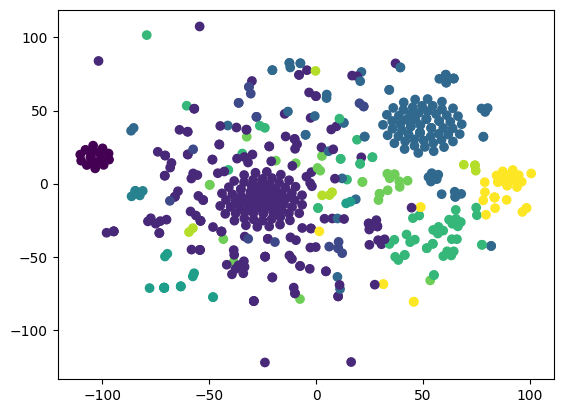

In [9]:
# 클러스터 결과 시각화
# T-SNE  차원 축소 방법 사용
# 고차원의 TF-IDF 벡터를 2차원으로 매핑한 후 클러스터링 결과를 시각화
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_tfidf.toarray())
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=kmeans.labels_)
plt.show()

In [18]:
from gensim.models import Word2Vec
from sklearn.cluster import KMeans

# 텍스트 전처리

# 문서를 단어 리스트로 변환
documents = [text.split() for text in book_df['t_p']]

In [29]:
# Word2Vec: 단어의 벡터 변환 모델 중 하나, 비슷한 의미를 가진 단어들이 벡터 공간에서 서로 가까이 위치하도록 학습
model = Word2Vec(sentences=documents, vector_size=100, window=5, min_count=1, workers=4)

# sentences=documents: 학습에 사용될 데이터(문서) 리스트 포맷(각 문서 내 단어들을 리스트)
# vector_size=100: 생성될 단어 벡터 차원 수
# window=5: 단어 예측을 위해 고려하는 주변 단어의 범위. 5:타겟 단어의 앞뒤로 5개의 단어를 컨텍스트로 사용
# min_count=1: 학습에 포함될 최소 단어 빈도수
# workers=4: 스레드의 수(병렬 처리)


#  문서 벡터 생성(<- 단어 벡터 평균)
def document_vector(word2vec_model, doc):
    vector_size = word2vec_model.vector_size   # 단어 벡터 차원 수

    doc_vector = np.zeros(vector_size) # 문서 벡터(초기값 0) 문서 내 각 단어의 벡터를 더함
    num_words = 0
    for word in doc:
        try:
            doc_vector += word2vec_model.wv[word]
            num_words += 1
        except KeyError: # 문서 내 단어의 수
            continue
    if num_words == 0:
        return np.zeros(vector_size)
    else:
        return doc_vector / num_words  # 각 단어 벡터를 더해서 구해진 doc_vector를 num_words로 나누어 평균 계산 (단어 벡터 평균)
                                       # 클러스터링의 input 으로 사용

# 각 문서 벡터 생성
doc_vectors = np.array([document_vector(model, doc) for doc in documents])
doc_vectors[0]

array([ 1.12721790e-03,  3.13190832e-03,  2.40769675e-03,  1.61313419e-03,
        1.88431179e-03, -4.25665267e-04, -3.02296819e-03,  2.34432761e-03,
       -3.22697954e-03,  2.29018352e-03, -3.94547309e-03,  1.19256901e-03,
        1.06248073e-03, -1.60556016e-03,  9.87586041e-04,  3.93776619e-04,
        4.67119971e-04,  2.17177565e-03, -5.35862392e-04,  2.83289524e-03,
       -6.93768822e-04, -1.52216097e-03,  4.58717509e-04, -4.43455957e-03,
        2.83488482e-03,  1.29308924e-04,  2.21993153e-03,  3.61407199e-03,
       -1.27217371e-03, -1.61739069e-03, -2.63812390e-03,  2.74560949e-03,
       -3.35358065e-03,  3.12388486e-03, -1.50566800e-03,  9.31382332e-04,
        4.64380179e-03, -2.14391450e-03,  6.61812909e-04,  2.37722243e-03,
        4.75657880e-03, -6.69155130e-04, -1.04432334e-03,  3.55159286e-03,
       -5.51707667e-03,  1.27583472e-03, -3.11099929e-03, -3.59034916e-03,
        2.16447472e-03, -5.35022314e-03, -1.93909903e-03,  8.19183595e-05,
       -5.29354671e-03, -

In [31]:
# K-평균 클러스터링 모델 생성 및 학습
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(doc_vectors)

# 클러스터 할당 결과
book_df['Cluster'] = kmeans.labels_


### **Word2Vec**
- 주변단어들을 학습에 사용
- CBOW
    - 주변 단어들(문맥)-타겟 단어의 앞뒤에 위치한 단어들-을 기반으로 타겟 단어 예측
    - ex "The cat sits on the ___" 빈칸에 들어갈 단어(타겟 단어) 예측
- Skip-gram
    - 특정 단어를 입력으로 받아, 그 단어 주변의 문맥 단어를 예측
    - ex "cat"이라는 단어가 주어졌을 때, 이 단어 주변에 위치할 가능성이 높은 단어("The", "sits", "on") 예측

In [10]:
################# Word2Vec  #################
from gensim.models import Word2Vec
import pandas as pd
import numpy as np

# 책 제목을 단어 리스트로 변환
sentences = [title.split() for title in book_df['Title']]

# Word2Vec 모델 학습
word2vec_model = Word2Vec(sentences, vector_size=64, window=5, min_count=1)
   # 책 제목에서 각 단어의 벡터 표현 학습
   # 학습을 통해 책 제목을 구성하는 단어들 간의 관계와 문맥을 바탕으로 각 단어의 의미를 반영하는 벡터 생성

In [32]:
# 책 제목 -> 벡터값 조회 및 제목단위 평균값 산출
# 학습된 word2vec 모델을 사용하여 각 책 제목을 구성하는 단어들의 벡터 값 조회
def vectorize_w_word2vec(text):
    words = text.split()
    word_vectors = [word2vec_model.wv[word] for word in words if word in word2vec_model.wv]
    if len(word_vectors) == 0:
        return np.zeros(word2vec_model.vector_size)
    return np.mean(word_vectors, axis=0)

# 각 책 제목을 벡터화
title_vectors_k = np.array([vectorize_w_word2vec(title) for title in book_df['Title']])

### 이 후 아래 클러스터링 코드 실행하여 결과 확인

### **FastText**
- 주변 단어들을 학습에 사용 =  word2vec
- 서브 워드 사용

In [12]:
################# FastText  #################
from gensim.models import FastText
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np

# FastText 모델 학습 (로컬 데이터)
# sentences = [title.split() for title in df_e['Title']]
sentences = [title.split() for title in book_df['Title']]
fasttext_model = FastText(sentences, vector_size=64, window=5, min_count=1)
   # 책 제목에서 각 단어와 서브워드(subword)의 벡터 표현 학습
   # 학습을 통해 책 제목을 구성하는 단어들 간의 관계와 문맥을 바탕으로 각 단어의 의미를 반영하는 벡터 생성

In [55]:
# 단어의 벡터 조회
print('단어벡터 : ',fasttext_model.wv['hello'], end='\n\n')

# 유사 단어 조회
for i in fasttext_model.wv.most_similar('hello'):
    print(i)

단어벡터 :  [ 1.0241700e-03  9.8525881e-05  1.5636896e-03  1.3075692e-04
 -8.2323130e-04  1.8038262e-04  5.7481877e-03  3.9245421e-03
 -7.9407394e-03 -3.3843629e-03  4.5048199e-03  1.1706334e-04
 -1.1677792e-03  1.5503652e-03 -1.0247971e-03  5.2458589e-04
  1.6638384e-03 -2.3499540e-04 -3.3412299e-03 -5.5561103e-03
  9.3087222e-04 -2.1214264e-03  2.6051011e-03 -2.2118662e-03
  5.7361386e-04  5.3387601e-04 -6.9579677e-05 -1.6973543e-03
 -1.4779690e-03  2.1319026e-03  2.8774941e-05 -4.6782661e-05
 -3.6206911e-04  1.1579808e-03 -6.7916670e-04  3.2917736e-04
  7.8443700e-04  4.2058175e-04 -6.6581924e-05 -1.2015655e-03
  1.5165460e-03  1.7554067e-03 -1.2368059e-03 -7.4982486e-04
 -7.3367864e-04  2.3937945e-03  6.9275132e-04 -2.7347559e-03
  4.0932689e-03  3.8002743e-03  1.8735334e-03 -9.6285046e-04
  4.0224129e-03 -2.6562458e-03 -7.6853606e-04  6.4338287e-03
  2.1509593e-04  2.1905606e-03 -1.7154722e-03  3.8727222e-03
  1.7452029e-03  2.3616408e-03  3.4930039e-04  3.2811358e-03]

('Poo', 0.4041

In [13]:
# 책 제목 -> 벡터값 조회 및 제목단위 평균값 산출
# 학습된 FastText 모델을 사용하여 각 책 제목을 구성하는 단어들의 벡터 값 조회
def vectorize_w_fasttext(text):
    words = text.split()
    word_vectors = [fasttext_model.wv[word] for word in words if word in fasttext_model.wv]
    if len(word_vectors) == 0:
        return np.zeros(fasttext_model.vector_size)
    return np.mean(word_vectors, axis=0)

# 제목 벡터화
title_vectors_k = np.array([vectorize_w_fasttext(title) for title in book_df['Title']])

In [14]:
# K-평균 클러스터링 수행
kmeans = KMeans(n_clusters=10, random_state=42)
kmeans.fit(title_vectors_k)

# 클러스터 할당 결과
book_df['Cluster'] = kmeans.labels_

- **아래 클러스터링 과정은 동일**

In [15]:
# 클러스터 별로 데이터 확인
for cluster in range(2): # 클러스터의 수에 따라 범위 조정
    print(f"Cluster {cluster}:")
    print(book_df[book_df['Cluster'] == cluster]['Title'].head(), '\n') # 각 클러스터에 속한 책 제목 출력


Cluster 0:
447                     La sonate a Kreutzer
3103                      A Girl Named Fancy
3153      Give Yourself a Chance to Know God
3155      Give Yourself a Chance to Know God
3270    Il ne fait pas toujours beau a Paris
Name: Title, dtype: object 

Cluster 1:
4311            Amy
4576    Irish Fever
4577    Irish Fever
4604            Mud
4605            Mud
Name: Title, dtype: object 



In [16]:
similar_words = fasttext_model.wv.most_similar('hey')

for word, similarity in similar_words:
    print(f"Word: {word}, similarity : {similarity}")

Word: Mammy, similarity : 0.4303036034107208
Word: They, similarity : 0.4227137267589569
Word: Edition, similarity : 0.3793039619922638
Word: Skin, similarity : 0.3677007257938385
Word: Ambition, similarity : 0.35832682251930237
Word: Tractor, similarity : 0.3511379659175873
Word: Dark, similarity : 0.3476412892341614
Word: 10, similarity : 0.34399330615997314
Word: Friends, similarity : 0.328824907541275
Word: Fred, similarity : 0.3272183835506439


In [17]:
# 유사한 단어
fasttext_model.wv.most_similar('hello')

[('Poo', 0.40416064858436584),
 ('Tells', 0.364960253238678),
 ('Past', 0.3643789291381836),
 ('Faces', 0.36306118965148926),
 ('SECOND', 0.36194005608558655),
 ('veri', 0.36056333780288696),
 ('Wand', 0.3488851487636566),
 ('Stormy', 0.3363569676876068),
 ('Gerald', 0.3361324965953827),
 ('Dogtor', 0.3279925286769867)]